# Exploratory Data Analysis (EDA) for License Plate Recognition

This notebook performs EDA on the License Plate Recognition project datasets:
1. **Detection Dataset**: YOLO format (COCO annotations)
2. **OCR Dataset**: PaddleOCR format (Images + Labels)

The goal is to ensure dataset quality, identify anomalies, and understand data distribution.

In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import matplotlib.patches as patches
import glob

%matplotlib inline
sns.set_style("whitegrid")

# Part A: Detection Dataset EDA (YOLO - Bounding Box)

We will analyze the COCO format annotations for the plate detection dataset.

In [2]:
# Define paths
DET_DATASET_PATH = "../datasets/IndonesianLiscenePlateDataset/plate_detection_dataset"
ANNOTATIONS_PATH = os.path.join(DET_DATASET_PATH, "annotations/annotations.json")
IMAGES_PATH = os.path.join(DET_DATASET_PATH, "images")

# Load annotations
if os.path.exists(ANNOTATIONS_PATH):
    with open(ANNOTATIONS_PATH, 'r') as f:
        coco_data = json.load(f)
    print(f"Loaded annotations from {ANNOTATIONS_PATH}")
    print(f"Keys: {coco_data.keys()}")
    print(f"Number of images: {len(coco_data['images'])}")
    print(f"Number of annotations: {len(coco_data['annotations'])}")
    print(f"Number of categories: {len(coco_data['categories'])}")
else:
    print(f"Annotation file not found at {ANNOTATIONS_PATH}")

Loaded annotations from ../datasets/IndonesianLiscenePlateDataset/plate_detection_dataset/annotations/annotations.json
Keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Number of images: 1377
Number of annotations: 2128
Number of categories: 1


## 1. Image Size Distribution
Check the distribution of image widths and heights. YOLO is sensitive to aspect ratios.

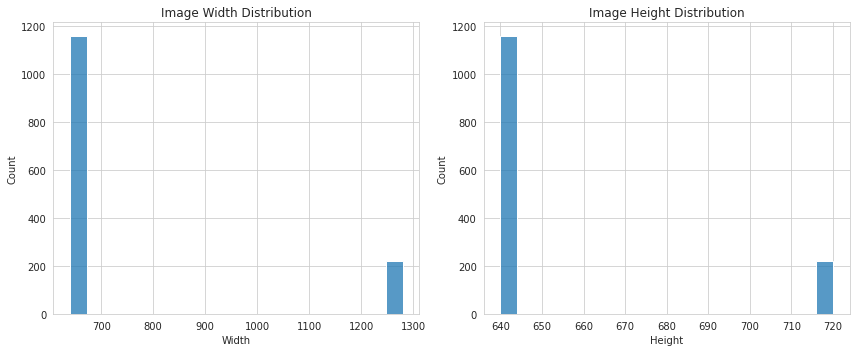

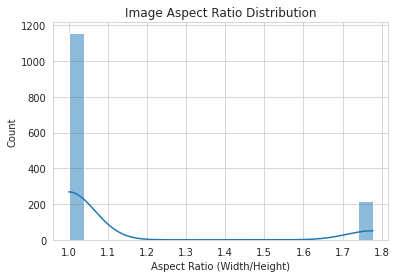

Common Image Sizes (WxH):
width  height
640    640       1158
1280   720        219
dtype: int64


In [3]:
if 'coco_data' in locals():
    img_df = pd.DataFrame(coco_data['images'])
    
    # Ensure numeric types to avoid matplotlib TypeError
    img_df['width'] = pd.to_numeric(img_df['width'], errors='coerce')
    img_df['height'] = pd.to_numeric(img_df['height'], errors='coerce')
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(img_df['width'], kde=False, bins=20)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    
    plt.subplot(1, 2, 2)
    sns.histplot(img_df['height'], kde=False, bins=20)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    
    plt.tight_layout()
    plt.show()
    
    # Aspect Ratio
    img_df['aspect_ratio'] = img_df['width'] / img_df['height']
    plt.figure(figsize=(6, 4))
    sns.histplot(img_df['aspect_ratio'], kde=True, bins=20)
    plt.title('Image Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.show()
    
    print("Common Image Sizes (WxH):")
    print(img_df.groupby(['width', 'height']).size().sort_values(ascending=False).head())

## 2. Objects per Image
Check how many bounding boxes are present in each image.

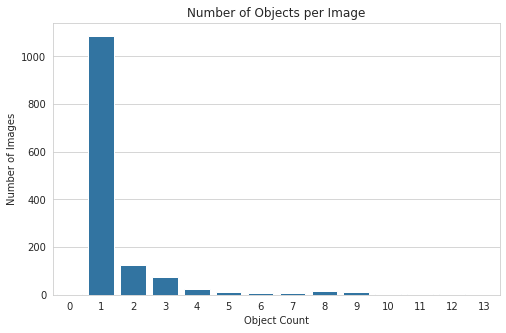

Images with 0 objects: 5
Images with >1 objects: 286


In [4]:
if 'coco_data' in locals():
    ann_df = pd.DataFrame(coco_data['annotations'])
    
    # Count annotations per image
    anns_per_img = ann_df.groupby('image_id').size()
    
    # Include images with 0 annotations
    all_img_ids = set(img_df['id'])
    ann_img_ids = set(anns_per_img.index)
    zero_ann_imgs = len(all_img_ids - ann_img_ids)
    
    # Add 0 counts
    counts = anns_per_img.value_counts().sort_index()
    if zero_ann_imgs > 0:
        counts[0] = zero_ann_imgs
        counts = counts.sort_index()
        
    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title('Number of Objects per Image')
    plt.xlabel('Object Count')
    plt.ylabel('Number of Images')
    plt.show()
    
    print(f"Images with 0 objects: {zero_ann_imgs}")
    print(f"Images with >1 objects: {len(anns_per_img[anns_per_img > 1])}")

## 3. Visualizing Sample Annotations
Visualizing random samples to check bounding box quality.

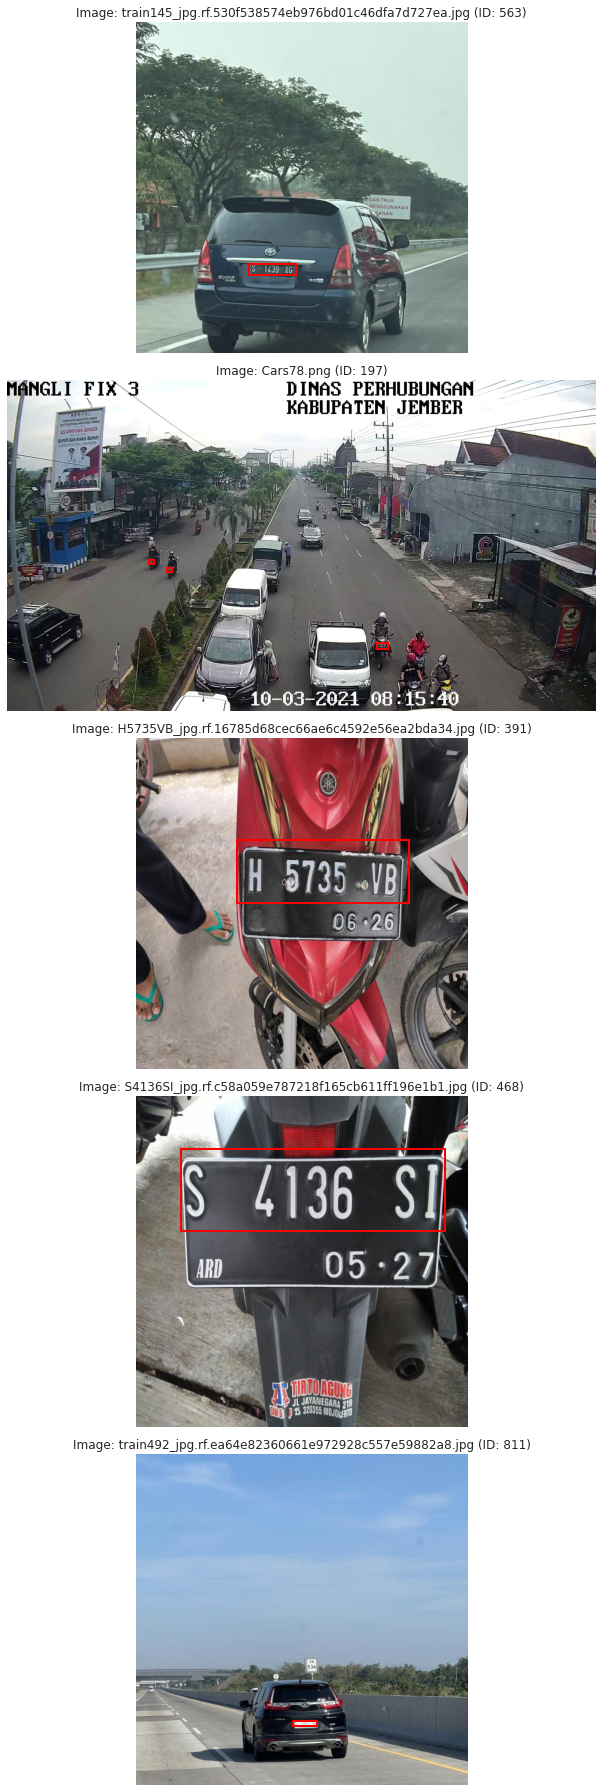

In [5]:
def show_sample_annotations(coco_data, images_dir, num_samples=5):
    import random
    
    img_ids = [img['id'] for img in coco_data['images']]
    sample_ids = random.sample(img_ids, num_samples)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, img_id in enumerate(sample_ids):
        img_info = next(img for img in coco_data['images'] if img['id'] == img_id)
        img_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]
        
        img_path = os.path.join(images_dir, img_info['file_name'])
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
            
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        
        ax = plt.gca()
        
        for ann in img_anns:
            bbox = ann['bbox'] # [x, y, width, height]
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
        plt.title(f"Image: {img_info['file_name']} (ID: {img_id})")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

if 'coco_data' in locals():
    show_sample_annotations(coco_data, IMAGES_PATH, num_samples=5)

## 4. Bounding Box Distribution
Analyze width, height, area, and aspect ratio of bounding boxes.

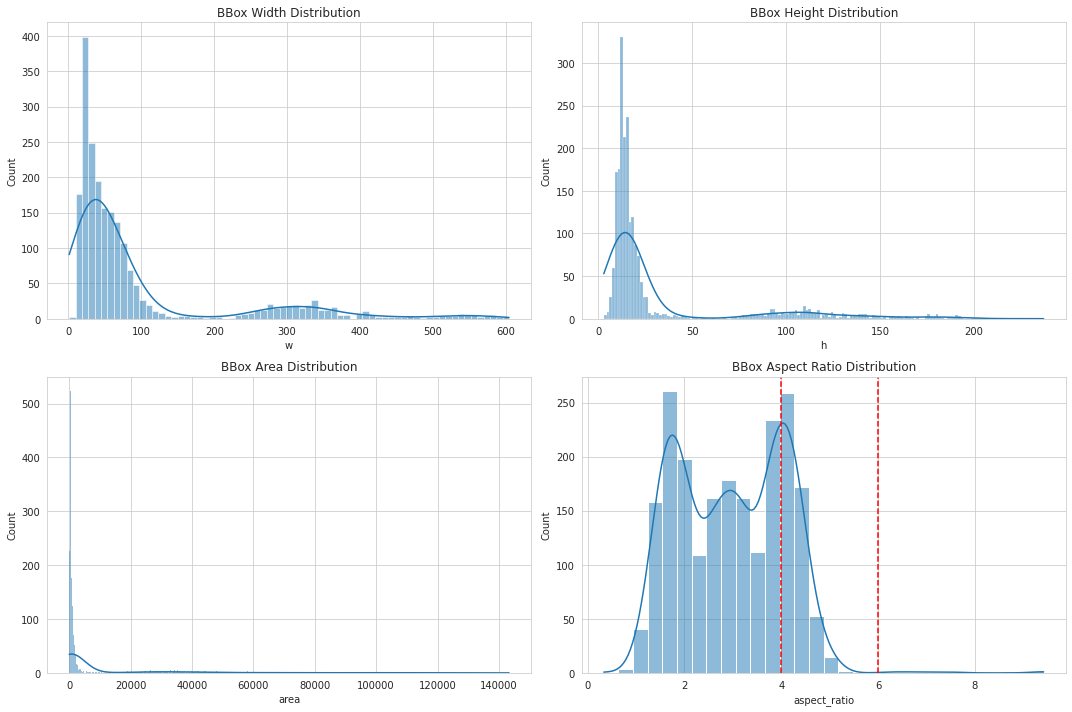

BBox Statistics:
                 x            y            w            h           area  \
count  2128.000000  2128.000000  2128.000000  2128.000000    2128.000000   
mean    438.880052   427.770089    97.691024    32.696664    8327.167058   
std     288.348755   134.309597   125.103794    41.924229   19933.311277   
min       0.000000    15.500000     1.000000     3.000000       3.000000   
25%     195.687500   381.937500    26.000000    12.000000     345.000000   
50%     368.125000   453.250000    47.500000    15.000000     630.000000   
75%     703.000000   512.812500    82.500000    21.500000    1741.750000   
max    1147.000000   704.000000   604.500000   237.000000  143266.500000   

       aspect_ratio  
count   2128.000000  
mean       2.973041  
std        1.091550  
min        0.333333  
25%        1.944444  
50%        3.000000  
75%        3.941597  
max        9.422222  

Plates with height < 30px: 1728 (81.20%)


In [6]:
if 'coco_data' in locals():
    # Extract bbox info
    bboxes = [ann['bbox'] for ann in coco_data['annotations']]
    bbox_df = pd.DataFrame(bboxes, columns=['x', 'y', 'w', 'h'])
    
    # Ensure numeric types
    bbox_df['w'] = pd.to_numeric(bbox_df['w'], errors='coerce')
    bbox_df['h'] = pd.to_numeric(bbox_df['h'], errors='coerce')
    
    bbox_df['area'] = bbox_df['w'] * bbox_df['h']
    bbox_df['aspect_ratio'] = bbox_df['w'] / bbox_df['h']
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(bbox_df['w'], kde=True)
    plt.title('BBox Width Distribution')
    
    plt.subplot(2, 2, 2)
    sns.histplot(bbox_df['h'], kde=True)
    plt.title('BBox Height Distribution')
    
    plt.subplot(2, 2, 3)
    sns.histplot(bbox_df['area'], kde=True)
    plt.title('BBox Area Distribution')
    
    plt.subplot(2, 2, 4)
    sns.histplot(bbox_df['aspect_ratio'], kde=True)
    plt.title('BBox Aspect Ratio Distribution')
    plt.axvline(x=4, color='r', linestyle='--')
    plt.axvline(x=6, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    print("BBox Statistics:")
    print(bbox_df.describe())
    
    # Check for small plates
    small_plates = bbox_df[bbox_df['h'] < 30]
    print(f"\nPlates with height < 30px: {len(small_plates)} ({len(small_plates)/len(bbox_df)*100:.2f}%)")

## 5. Bounding Box Position Heatmap
Check where the plates are located in the images.

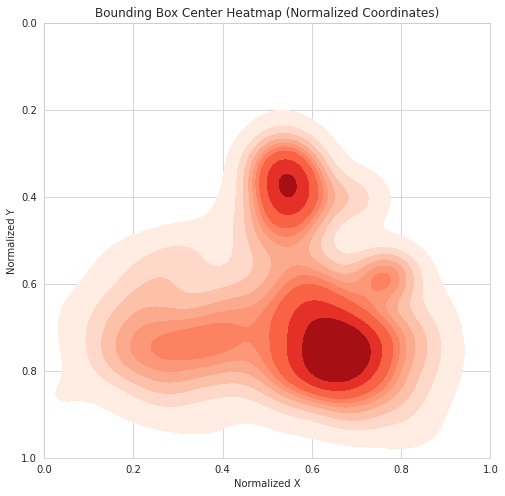

In [7]:
if 'coco_data' in locals():
    # Calculate centers
    bbox_df['cx'] = bbox_df['x'] + bbox_df['w'] / 2
    bbox_df['cy'] = bbox_df['y'] + bbox_df['h'] / 2
    
    # Create a map of image id to size
    img_size_map = {img['id']: (float(img['width']), float(img['height'])) for img in coco_data['images']}
    
    norm_cx = []
    norm_cy = []
    
    for ann in coco_data['annotations']:
        img_w, img_h = img_size_map[ann['image_id']]
        bbox = ann['bbox']
        cx = bbox[0] + bbox[2] / 2
        cy = bbox[1] + bbox[3] / 2
        norm_cx.append(cx / img_w)
        norm_cy.append(cy / img_h)
        
    plt.figure(figsize=(8, 8))
    sns.kdeplot(x=norm_cx, y=norm_cy, fill=True, cmap="Reds", thresh=0.05)
    plt.xlim(0, 1)
    plt.ylim(1, 0) # Invert Y axis for image coordinates
    plt.title('Bounding Box Center Heatmap (Normalized Coordinates)')
    plt.xlabel('Normalized X')
    plt.ylabel('Normalized Y')
    plt.show()

## 6. Data Integrity Check
Check for missing files or invalid annotations.

In [8]:
if 'coco_data' in locals():
    missing_images = []
    for img in coco_data['images']:
        img_path = os.path.join(IMAGES_PATH, img['file_name'])
        if not os.path.exists(img_path):
            missing_images.append(img['file_name'])
            
    print(f"Total Images in Annotations: {len(coco_data['images'])}")
    print(f"Missing images: {len(missing_images)}")
    if missing_images:
        print(f"First 5 missing: {missing_images[:5]}")
    else:
        print("All images found!")

Total Images in Annotations: 1377
Missing images: 3
First 5 missing: ['Cars00171.png', 'Cars00221.png', 'Cars00531.png']


# Part B: OCR Dataset EDA (Text Recognition)

We will analyze the OCR dataset which consists of images and a label file.

In [9]:
OCR_DATASET_PATH = "../datasets/IndonesianLiscenePlateDataset/plate_text_dataset"
LABEL_FILE = os.path.join(OCR_DATASET_PATH, "label.csv")
OCR_IMAGES_DIR = os.path.join(OCR_DATASET_PATH, "dataset")

if os.path.exists(LABEL_FILE):
    ocr_df = pd.read_csv(LABEL_FILE)
    print(f"Loaded labels from {LABEL_FILE}")
    print(ocr_df.head())
    print(f"Total samples: {len(ocr_df)}")
else:
    print(f"Label file not found at {LABEL_FILE}")

Loaded labels from ../datasets/IndonesianLiscenePlateDataset/plate_text_dataset/label.csv
       filename     label
0  AA4795BE.jpg  AA4795BE
1  BH2618MA.jpg  BH2618MA
2   H2148BL.jpg   H2148BL
3   H2441WB.jpg   H2441WB
4  H2512AOC.jpg  H2512AOC
Total samples: 1863


## 1. Text Length Distribution
Check the length of the license plate texts.

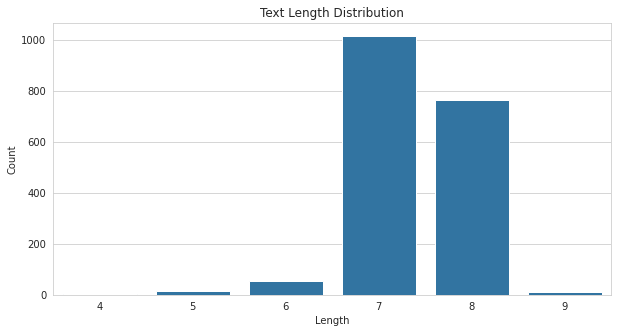

In [10]:
if 'ocr_df' in locals():
    # Ensure label is string
    ocr_df['label'] = ocr_df['label'].astype(str)
    ocr_df['length'] = ocr_df['label'].apply(len)
    
    plt.figure(figsize=(10, 5))
    sns.countplot(x='length', data=ocr_df)
    plt.title('Text Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Count')
    plt.show()

## 2. Character Set Analysis
Identify all unique characters and check for invalid ones.

Unique characters (36): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


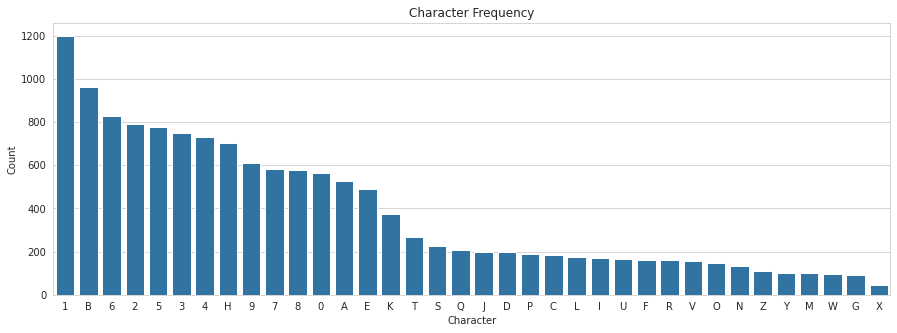

In [11]:
if 'ocr_df' in locals():
    all_text = "".join(ocr_df['label'].tolist())
    unique_chars = sorted(list(set(all_text)))
    print(f"Unique characters ({len(unique_chars)}): {unique_chars}")
    
    # Character frequency
    char_counts = Counter(all_text)
    char_df = pd.DataFrame.from_dict(char_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    
    plt.figure(figsize=(15, 5))
    sns.barplot(x=char_df.index, y=char_df['count'])
    plt.title('Character Frequency')
    plt.xlabel('Character')
    plt.ylabel('Count')
    plt.show()

## 3. Character Balance (Letters vs Numbers)
Check the proportion of letters and numbers.

Total Characters: 13740
Digits: 7400 (53.9%)
Letters: 6340 (46.1%)
Others: 0 (0.0%)


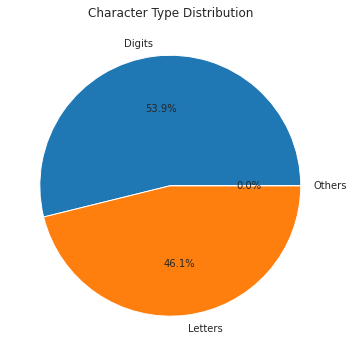

In [12]:
if 'ocr_df' in locals():
    all_text = "".join(ocr_df['label'].tolist())
    total_chars = len(all_text)
    digits = sum(c.isdigit() for c in all_text)
    letters = sum(c.isalpha() for c in all_text)
    others = total_chars - digits - letters
    
    print(f"Total Characters: {total_chars}")
    print(f"Digits: {digits} ({digits/total_chars*100:.1f}%)")
    print(f"Letters: {letters} ({letters/total_chars*100:.1f}%)")
    print(f"Others: {others} ({others/total_chars*100:.1f}%)")
    
    plt.figure(figsize=(6, 6))
    plt.pie([digits, letters, others], labels=['Digits', 'Letters', 'Others'], autopct='%1.1f%%')
    plt.title('Character Type Distribution')
    plt.show()

## 4. Visualizing Sample OCR Images
Check quality of cropped images.

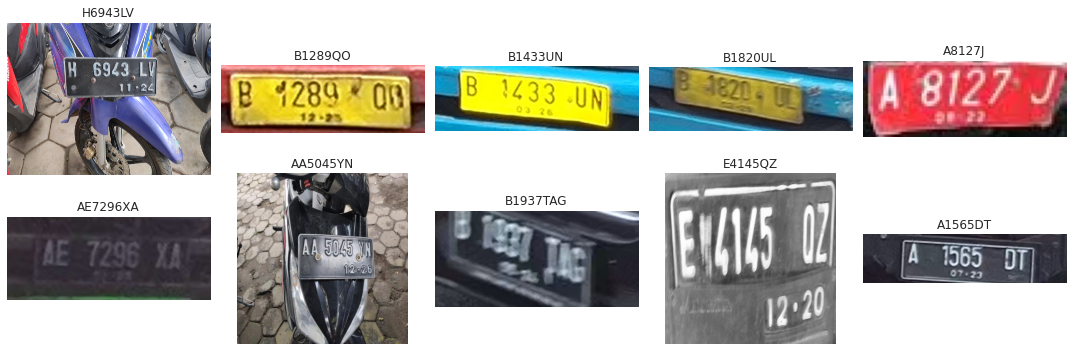

In [13]:
def show_ocr_samples(ocr_df, images_dir, num_samples=10):
    if len(ocr_df) == 0:
        return
        
    samples = ocr_df.sample(num_samples)
    
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(images_dir, row['filename'])
        label = row['label']
        
        if not os.path.exists(img_path):
            pass
            
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(2, 5, i+1)
                plt.imshow(img)
                plt.title(label)
                plt.axis('off')
            else:
                print(f"Could not read image: {img_path}")
        else:
            print(f"Image not found: {img_path}")
            
    plt.tight_layout()
    plt.show()

if 'ocr_df' in locals():
    show_ocr_samples(ocr_df, OCR_IMAGES_DIR, num_samples=10)

## 5. Image Quality Analysis
Analyze brightness, contrast, and resolution.

Analyzing Image Quality: 100%|██████████| 500/500 [00:10<00:00, 45.55it/s]


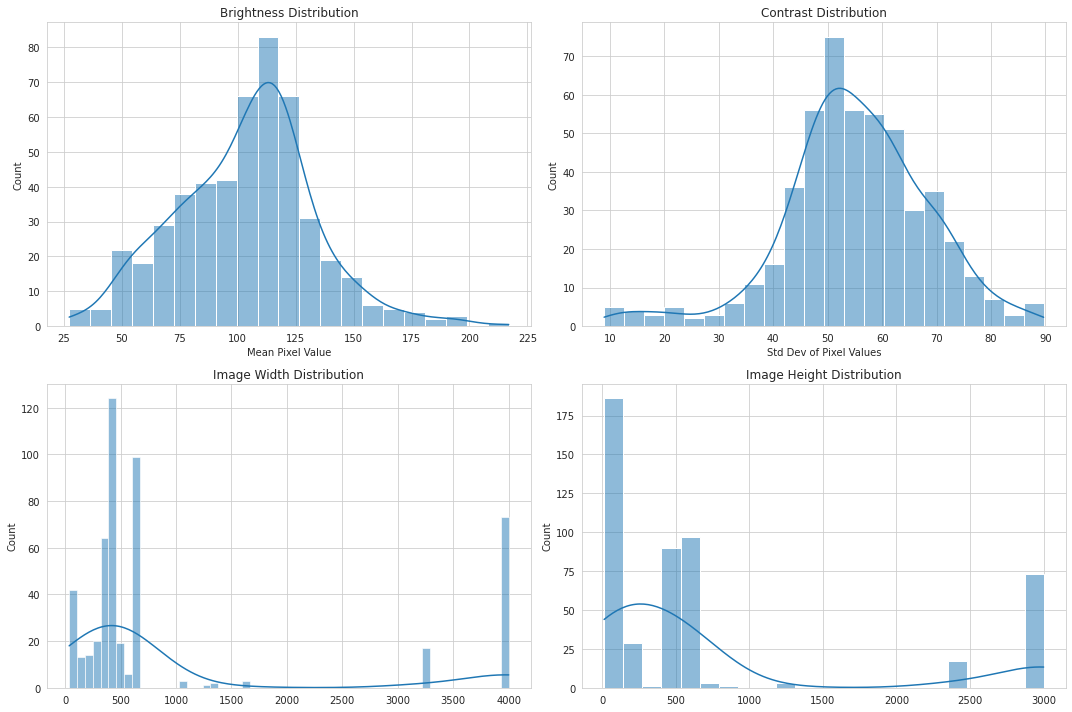

Average Size: 1046.5x777.2
Min Height: 14, Max Height: 3000
Images with height < 30px: 22


In [14]:
def calculate_image_stats(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    contrast = np.std(gray)
    h, w = gray.shape
    return brightness, contrast, w, h

if 'ocr_df' in locals():
    brightness_vals = []
    contrast_vals = []
    widths = []
    heights = []
    
    # Sample 500 images for speed if needed, or all
    sample_df = ocr_df.sample(min(len(ocr_df), 500))
    
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Analyzing Image Quality"):
        img_path = os.path.join(OCR_IMAGES_DIR, row['filename'])
        if os.path.exists(img_path):
            stats = calculate_image_stats(img_path)
            if stats:
                brightness_vals.append(stats[0])
                contrast_vals.append(stats[1])
                widths.append(stats[2])
                heights.append(stats[3])
                
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(brightness_vals, kde=True)
    plt.title('Brightness Distribution')
    plt.xlabel('Mean Pixel Value')
    
    plt.subplot(2, 2, 2)
    sns.histplot(contrast_vals, kde=True)
    plt.title('Contrast Distribution')
    plt.xlabel('Std Dev of Pixel Values')
    
    plt.subplot(2, 2, 3)
    sns.histplot(widths, kde=True)
    plt.title('Image Width Distribution')
    
    plt.subplot(2, 2, 4)
    sns.histplot(heights, kde=True)
    plt.title('Image Height Distribution')
    
    plt.tight_layout()
    plt.show()
    
    if heights:
        print(f"Average Size: {np.mean(widths):.1f}x{np.mean(heights):.1f}")
        print(f"Min Height: {np.min(heights)}, Max Height: {np.max(heights)}")
        small_ocr = [h for h in heights if h < 30]
        print(f"Images with height < 30px: {len(small_ocr)}")